Esse código foi feito para aplicar o algoritmo de random forest para realizar uma previsão momentânea do valor
 de Potência gerada e comparar o resultado com o valor obtido por meio do modelo de equação única, ou também conhecido como modelo físico
 

# Importando bibliotecas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

from Functions import import_PV_WT_data


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


#importando e definindo a função necessária para calcular r²
from scipy import stats
from scipy.optimize import curve_fit
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

# Lendo os dados previamente limpos pelo arquivo "ExtraindoDadosSolete.ipynb"

In [3]:
#Importando os dados já limpos e trabalhados (sem falhas)
DATA=pd.read_csv('Data/Solete/ResampleHoraSemFalha.csv',index_col = 0, parse_dates=True)
PVinfo, WTinfo = import_PV_WT_data()

DATA.head()

,TEMPERATURE[degC],HUMIDITY[%],WIND_SPEED[m1s],WIND_DIR[deg],GHI[kW1m2],POA Irr[kW1m2],P_Gaia[kW],P_Solar[kW],Pressure[mbar],PR_A,Pac,Pdc,TempModule,TempCell
2018-06-01 04:00:00,14.956095,0.700000,1.252238,90.303333,0.137325,0.056974,0.000671,0.316833,1016.824675,0.771259,0.432287,0.440659,16.430217,16.601139
2018-06-01 05:00:00,16.359278,0.700000,1.571111,99.760833,0.225724,0.074395,0.056381,0.457303,1016.921153,0.851619,0.559628,0.570467,18.238640,18.461825
2018-06-01 06:00:00,18.266389,0.633500,1.654250,101.448611,0.344626,0.143629,0.034202,0.981629,1016.602885,0.959274,1.058032,1.078524,21.879632,22.310520
2018-06-01 07:00:00,20.064750,0.587972,1.555750,99.841944,0.451299,0.342008,0.002903,2.350645,1016.332812,0.954127,2.435991,2.483171,28.717007,29.743032
2018-06-01 08:00:00,21.713278,0.499583,1.627639,106.434167,0.540191,0.538267,0.003948,3.661579,1016.145600,0.945578,3.704321,3.776067,35.266054,36.880854


## Visualisando os dados

In [4]:
P = "P_Solar[kW]"
DATA['P/Pac'] = DATA[P] / DATA['Pac']
IRR = "POA Irr[kW1m2]"

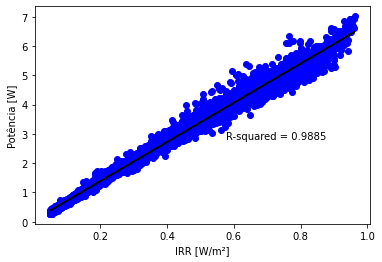

R-square =  0.9885398006396707


In [5]:
#Plotando um gráfico scatter de todos os dias com uma fit line e o R²
plt.scatter(DATA[IRR],DATA[P], color = "blue")
plt.xlabel("IRR [W/m²]")
plt.ylabel("Potência [W]")

a, b = np.polyfit(DATA[IRR],DATA[P], 1) #Encontrando a melhor fit line (R²) entre os dois valores
plt.plot(DATA[IRR], a*DATA[IRR]+b, color = "black",)
r2 = rsquared(DATA[IRR],DATA[P])
plt.text(0.6*DATA[IRR].max(), 0.4*DATA[P].max(), 'R-squared = %0.4f' % r2, color = "black")
plt.show()

print("R-square = ", r2)

# Aplicando Machine Learning na faixa global de irradiância

## Separando em variaveis de X e Y (possible features and features to be predicted)

In [6]:
df2 = DATA.copy()
X = df2[['TEMPERATURE[degC]', 'HUMIDITY[%]', 'POA Irr[kW1m2]', 'Pac', 'TempModule', 'TempCell', 'GHI[kW1m2]']]
y = df2[['P_Solar[kW]']]

In [7]:
# Separando as variáveis de treinamento e teste
X_train_global,X_test_global,y_train_global,y_test_global = train_test_split(X,y,test_size=.3,random_state=21,shuffle=False)

## Treinando e testando o RandomForest (RF)

In [8]:
rfr = RandomForestRegressor()
rfr.fit(X_train_global,y_train_global)
y_pred_rfr = rfr.predict(X_test_global)
R2_Score_rfr = round(r2_score(y_pred_rfr,y_test_global) * 100, 2)

print("R2 Score : ",R2_Score_rfr,"%")

C:\Users\Bruno\AppData\Local\Temp\ipykernel_21316\1360400851.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train_global,y_train_global)


R2 Score :  98.77 %


In [9]:
PredictionGlobal = rfr.predict(X_test_global)
print(type(PredictionGlobal))
print(PredictionGlobal)
df_predictGlobal = pd.DataFrame(PredictionGlobal, columns = ["P_Solar[kW]"], index = y_test_global.index)

<class 'numpy.ndarray'>
[2.79528866 4.06502602 4.77690531 ... 2.62766828 1.27254375 0.41950514]


### Prevendo os valores para os dados de teste para obter os limites superiores e inferiores da detecção

In [10]:
PredictionGlobal_train = rfr.predict(X_train_global)
df_predictGlobal_train = pd.DataFrame(PredictionGlobal_train, columns = ["P_Solar[kW]"], index = y_train_global.index)
df_predictGlobal_train['P/PacRF'] = y_train_global[P] / df_predictGlobal_train[P]


In [11]:
RMSE_RF_Train = mean_squared_error(y_train_global, df_predictGlobal_train[P]) * 100
RMSE_RF_Train

0.17436569123487966

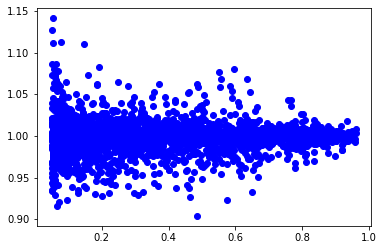

In [12]:
plt.scatter(X_train_global[IRR],df_predictGlobal_train['P/PacRF'], color = 'blue')

In [13]:
print("Tamanho da predição",df_predictGlobal.shape[0],"Tamanho do y_teste",y_test_global.shape[0])
print("Tamanho total",df2.shape[0],"Tamanho do y_train",y_train_global.shape[0])

Tamanho da predição 1406 Tamanho do y_teste 1406
Tamanho total 4685 Tamanho do y_train 3279


## Treinando e testando o One-Equation(OE)

In [14]:
# define the true objective function
def func(data, a, b, c, d):
    x = data[0] * 1000
    z = data[1]
    return x * (a + b * x + c * np.log(x)) * (1 + d * (z - 25))

In [15]:
#Variaveis indepentendes
df_X_train_global_oe = X_train_global.copy()
df_X_train_global_oe_data = df_X_train_global_oe.values

#Variavel dependente
df_y_train_global_oe = y_train_global.copy()
df_y_train_global_oe_data = df_y_train_global_oe.values

# Separando os dados de treinamento
irradiation = df_X_train_global_oe_data[:, 2]
moduletemperature = df_X_train_global_oe_data[:, 4]
energy = df_y_train_global_oe_data[:, 0]

In [16]:
# Treinando a curve fit com os dados de treinamento
popt, pcov = curve_fit(func, (irradiation, moduletemperature), energy)
# Encontrando os parametros
a, b, c, d = popt
print('a1 = %.5f, a2 = %.5f, a3 = %.5f, a4 = %.5f' % (a, b, c, d))

a1 = 0.00397, a2 = -0.00000, a3 = 0.00061, a4 = -0.00416


In [17]:
# Calculando a razão P/PacOE para os dados de teste
PredictionGlobalOE = X_test_global[IRR]*1000 * (a + b * X_test_global[IRR]*1000 + c * np.log(X_test_global[IRR]*1000)) * (1 + d * (X_test_global['TempModule'] - 25))
df_predictGlobalOE = pd.DataFrame(PredictionGlobalOE, columns = ["P_Solar[kW]"], index = y_test_global.index)
df_predictGlobalOE["P"] = y_test_global[P]


## Calculando o RMSE

In [18]:
RMSE_RF = mean_squared_error(y_test_global, df_predictGlobal) * 100
RMSE_RF

3.368554889781019

In [19]:
RMSE_OE = mean_squared_error(y_test_global, df_predictGlobalOE[P])*100
RMSE_OE

3.805385936374416

In [20]:
RMSE_MF = mean_squared_error(y_test_global, X_test_global['Pac']) * 100
Pac_Faixa_Global = X_test_global # Adquirindo o valor de Pac dos dados utilizados para teste para salvar junto com os resultados
RMSE_MF

4.9896600028676925

# Aplicando Machine Learning nas três faixas separadas de irradiância

In [21]:
# Separando as três faixas
selecao_faixa1 = (df2[IRR] >= 50/1000) & (df2[IRR] <= 250/1000)
selecao_faixa2 = (df2[IRR] > 250/1000) & (df2[IRR] <= 500/1000)
selecao_faixa3 = (df2[IRR] > 500/1000)

df2_faixa1 = df2[selecao_faixa1]
df2_faixa2 = df2[selecao_faixa2]
df2_faixa3 = df2[selecao_faixa3]

## Treinando RF e OE para cada faixa

## Faixa 1 (50-250)

In [22]:
X = df2_faixa1[['TEMPERATURE[degC]', 'HUMIDITY[%]', 'POA Irr[kW1m2]', 'Pac', 'TempModule', 'TempCell', 'GHI[kW1m2]']]
y = df2_faixa1[['P_Solar[kW]']]
X_train_faixa1,X_test_faixa1,y_train_faixa1,y_test_faixa1 = train_test_split(X,y,test_size=.31,random_state=21,shuffle=False)

### RF

In [23]:
rfr = RandomForestRegressor()
rfr.fit(X_train_faixa1,y_train_faixa1)
y_pred_rfr = rfr.predict(X_test_faixa1)
R2_Score_rfr = round(r2_score(y_pred_rfr,y_test_faixa1) * 100, 2)


C:\Users\Bruno\AppData\Local\Temp\ipykernel_21316\210803122.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train_faixa1,y_train_faixa1)


In [24]:
PredictionFaixa1 = y_pred_rfr
print(type(PredictionFaixa1))
df_predictFaixa1 = pd.DataFrame(PredictionFaixa1, columns = ["P_Solar[kW]"], index = y_test_faixa1.index)

<class 'numpy.ndarray'>


### One-Equation

In [25]:
#Variaveis indepentendes
df_X_train_faixa1_oe = X_train_faixa1.copy()
df_X_train_faixa1_oe_data = df_X_train_faixa1_oe.values

#Variavel dependente
df_y_train_faixa1_oe = y_train_faixa1.copy()
df_y_train_faixa1_oe_data = df_y_train_faixa1_oe.values

# Separando os dados de treinamento
irradiation = df_X_train_faixa1_oe_data[:, 2]
moduletemperature = df_X_train_faixa1_oe_data[:, 4]
energy = df_y_train_faixa1_oe_data[:, 0]

In [26]:
# Treinando a curve fit com os dados de treinamento
popt, pcov = curve_fit(func, (irradiation, moduletemperature), energy)
# Encontrando os parametros
a1, b1, c1, d1 = popt
print('a1 = %.5f, a2 = %.5f, a3 = %.5f, a4 = %.5f' % (a1, b1, c1, d1))

a1 = 0.00238, a2 = -0.00000, a3 = 0.00102, a4 = -0.00210


In [27]:
# Calculando a razão P/PacOE para os dados de teste
PredictionFaixa1OE = X_test_faixa1[IRR]*1000 * (a1 + b1 * X_test_faixa1[IRR]*1000 + c1 * np.log(X_test_faixa1[IRR]*1000)) * (1 + d1 * (X_test_faixa1['TempModule'] - 25))
df_predictFaixa1OE = pd.DataFrame(PredictionFaixa1OE, columns = ["P_Solar[kW]"], index = y_test_faixa1.index)
df_predictFaixa1OE["P"] = y_test_faixa1[P]


### RMSE

In [28]:
RMSE_RF_faixa1 = mean_squared_error(y_test_faixa1, df_predictFaixa1) * 100
RMSE_RF_faixa1

0.4259216025116817

In [29]:
RMSE_OE_faixa1 = mean_squared_error(y_test_faixa1, df_predictFaixa1OE[P]) * 100
RMSE_OE_faixa1

0.3901511080910956

In [30]:
RMSE_MF_faixa1 = mean_squared_error(y_test_faixa1, X_test_faixa1['Pac']) * 100
RMSE_MF_faixa1

1.1670635581110418

## Faixa 2 (250-500)

In [31]:
X = df2_faixa2[['TEMPERATURE[degC]', 'HUMIDITY[%]', 'POA Irr[kW1m2]', 'Pac', 'TempModule', 'TempCell', 'GHI[kW1m2]']]
y = df2_faixa2[['P_Solar[kW]']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.33,random_state=21,shuffle=False)

In [32]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)
R2_Score_rfr = round(r2_score(y_pred_rfr,y_test) * 100, 2)

C:\Users\Bruno\AppData\Local\Temp\ipykernel_21316\1857572404.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train,y_train)


In [33]:
PredictionFaixa2 = y_pred_rfr
print(type(PredictionFaixa2))
df_predictFaixa2 = pd.DataFrame(PredictionFaixa2, columns = ["P_Solar[kW]"], index = y_test.index)

<class 'numpy.ndarray'>


### One-equation

In [34]:
#Variaveis indepentendes
df_X_train_faixa2_oe = X_train.copy()
df_X_train_faixa2_oe_data = df_X_train_faixa2_oe.values

#Variavel dependente
df_y_train_faixa2_oe = y_train.copy()
df_y_train_faixa2_oe_data = df_y_train_faixa2_oe.values

# Separando os dados de treinamento
irradiation = df_X_train_faixa2_oe_data[:, 2]
moduletemperature = df_X_train_faixa2_oe_data[:, 4]
energy = df_y_train_faixa2_oe_data[:, 0]

In [35]:
# Treinando a curve fit com os dados de treinamento
popt, pcov = curve_fit(func, (irradiation, moduletemperature), energy)
# Encontrando os parametros
a2, b2, c2, d2 = popt
print('a1 = %.5f, a2 = %.5f, a3 = %.5f, a4 = %.5f' % (a2, b2, c2, d2))

a1 = 0.01620, a2 = 0.00001, a3 = -0.00189, a4 = -0.00257


In [36]:
# Calculando a razão P/PacOE para os dados de teste
PredictionFaixa2OE = X_test[IRR]*1000 * (a2 + b2 * X_test[IRR]*1000 + c2 * np.log(X_test[IRR]*1000)) * (1 + d2 * (X_test['TempModule'] - 25))
df_predictFaixa2OE = pd.DataFrame(PredictionFaixa2OE, columns = ["P_Solar[kW]"], index = y_test.index)
df_predictFaixa2OE["P"] = y_test[P]

### RMSE

In [37]:
RMSE_RF_faixa2 = mean_squared_error(y_test, df_predictFaixa2) * 100
RMSE_RF_faixa2

3.347539352421648

In [38]:
RMSE_OE_faixa2 = mean_squared_error(y_test, df_predictFaixa2OE[P]) * 100
RMSE_OE_faixa2

4.048009051816145

In [39]:
RMSE_MF_faixa2 = mean_squared_error(y_test, X_test['Pac']) * 100
RMSE_MF_faixa2

3.8543990187507196

## Faixa 3 (500+)

In [40]:
X = df2_faixa3[['TEMPERATURE[degC]', 'HUMIDITY[%]', 'POA Irr[kW1m2]', 'Pac', 'TempModule', 'TempCell', 'GHI[kW1m2]']]
y = df2_faixa3[['P_Solar[kW]']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=21,shuffle=False)

In [41]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)
R2_Score_rfr = round(r2_score(y_pred_rfr,y_test) * 100, 2)

C:\Users\Bruno\AppData\Local\Temp\ipykernel_21316\1857572404.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train,y_train)


In [42]:
PredictionFaixa3 = y_pred_rfr
print(type(PredictionFaixa3))
df_predictFaixa3 = pd.DataFrame(PredictionFaixa3, columns = ["P_Solar[kW]"], index = y_test.index)

<class 'numpy.ndarray'>


### One-Equation

In [43]:
#Variaveis indepentendes
df_X_train_faixa3_oe = X_train.copy()
df_X_train_faixa3_oe_data = df_X_train_faixa3_oe.values

#Variavel dependente
df_y_train_faixa3_oe = y_train.copy()
df_y_train_faixa3_oe_data = df_y_train_faixa3_oe.values

# Separando os dados de treinamento
irradiation = df_X_train_faixa3_oe_data[:, 2]
moduletemperature = df_X_train_faixa3_oe_data[:, 4]
energy = df_y_train_faixa3_oe_data[:, 0]

In [44]:
# Treinando a curve fit com os dados de treinamento
popt, pcov = curve_fit(func, (irradiation, moduletemperature), energy)
# Encontrando os parametros
a3, b3, c3, d3 = popt
print('a1 = %.5f, a2 = %.5f, a3 = %.5f, a4 = %.5f' % (a3, b3, c3, d3))

a1 = 0.00671, a2 = -0.00000, a3 = 0.00010, a4 = -0.00450


In [45]:
# Calculando a razão P/PacOE para os dados de teste
PredictionFaixa3OE = X_test[IRR]*1000 * (a3 + b3 * X_test[IRR]*1000 + c3 * np.log(X_test[IRR]*1000)) * (1 + d3 * (X_test['TempModule'] - 25))
df_predictFaixa3OE = pd.DataFrame(PredictionFaixa3OE, columns = ["P_Solar[kW]"], index = y_test.index)
df_predictFaixa3OE["P"] = y_test[P]

### RMSE

In [46]:
RMSE_RF_faixa3 = mean_squared_error(y_test, df_predictFaixa3) * 100
RMSE_RF_faixa3

10.043311896429238

In [47]:
RMSE_OE_faixa3 = mean_squared_error(y_test, df_predictFaixa3OE[P]) * 100
RMSE_OE_faixa3

11.025864131804894

In [48]:
RMSE_MF_faixa3 = mean_squared_error(y_test, X_test['Pac']) * 100
RMSE_MF_faixa3

13.490149136805304

# Visualizando os resultados

In [49]:
data2 = ((RMSE_RF, RMSE_MF, RMSE_OE),
        (RMSE_RF_faixa1, RMSE_MF_faixa1, RMSE_OE_faixa1),
        (RMSE_RF_faixa2, RMSE_MF_faixa2, RMSE_OE_faixa2),
        (RMSE_RF_faixa3, RMSE_MF_faixa3, RMSE_OE_faixa3)
)

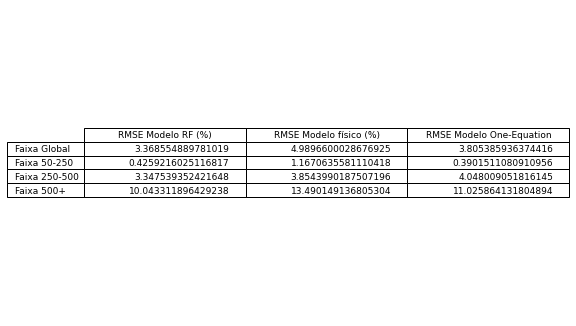

In [50]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(1, 1)
columns = ('RMSE Modelo RF (%)', 'RMSE Modelo físico (%)', 'RMSE Modelo One-Equation')
rows = ['Faixa Global', 'Faixa 50-250','Faixa 250-500', 'Faixa 500+']
axs.axis('tight')
axs.axis('off')
the_table = axs.table(loc='center',cellText = data2, colLabels=columns,rowLabels= rows)
plt.show()

# Salvando os resultados em dataframe

In [51]:
result = pd.DataFrame(index = df_predictGlobal.index) 
result['RF_Global'] = df_predictGlobal['P_Solar[kW]']
result['RF_Faixa1'] = df_predictFaixa1['P_Solar[kW]']
result['RF_Faixa2'] = df_predictFaixa2['P_Solar[kW]']
result['RF_Faixa3'] = df_predictFaixa3['P_Solar[kW]']

result['OE_Global'] = df_predictGlobalOE['P_Solar[kW]']
result['OE_Faixa1'] = df_predictFaixa1OE['P_Solar[kW]']
result['OE_Faixa2'] = df_predictFaixa2OE['P_Solar[kW]']
result['OE_Faixa3'] = df_predictFaixa3OE['P_Solar[kW]']

result.to_csv('Data/Solete/ML_Result.csv')

In [52]:
#Salvando os tranining dataset para futura identificação de falhas
df_X_train_global = pd.DataFrame(X_train_global, index = X_train_global.index)
df_X_train_global[P] =  y_train_global[P]
df_X_train_global['P/Pac'] = df_X_train_global[P] / df_X_train_global['Pac']

# Calculando a razão P/PacOE para os dados de treinamento da faixa global no modelo One-Equation
df_X_train_global['PacOE'] = df_X_train_global[IRR]*1000 * (a + b * df_X_train_global[IRR]*1000 + c * np.log(df_X_train_global[IRR]*1000)) * (1 + d * (df_X_train_global['TempModule'] - 25))
df_X_train_global['P/PacOE'] = y_train_global[P]/df_X_train_global['PacOE']
del df_X_train_global['PacOE']

# Calculando a razão P/PacRF para os dados de treinamento da faixa global no modelo Random Forest
df_X_train_global['P/PacRF'] = df_predictGlobal_train['P/PacRF']

df_X_train_global.to_csv('Data/Solete/ML_Train.csv') # all machine learnings training data